In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import librosa.display
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.src.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
DATA_TRAIN = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_train\\raw_crowd_train.tsv"
AUDIO_TRAIN = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_train\\wavs\\"

DATA_TEST = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_test\\raw_crowd_test.tsv"
AUDIO_TEST = "C:\\Users\\s5pen\\YandexDisk\\ВКР\\crowd_test\\wavs\\"

EPOCH = 200
data_train = pd.read_csv(DATA_TRAIN, delimiter='\t')

data_train.head(5)


,hash_id,audio_path,duration,annotator_emo,golden_emo,annotator_id,speaker_text,speaker_emo,source_id
0,475e76f77ac1ed7cabafca740b15b32a,wavs/475e76f77ac1ed7cabafca740b15b32a.wav,2.453000,angry,NaN,858305a5450b7bd1288ba0053b1cd1c1,не надо не надо не надо не надо,angry,fa136da095807ea6cd18dd6e2f58d4d0
1,2f9438ef68395c70a8714dc373a49d11,wavs/2f9438ef68395c70a8714dc373a49d11.wav,4.640000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,фозил кори mp три,neutral,3d436884cbbe25373914f8768de494f7
2,9937036a9c0dba20eecbffddd00f2be2,wavs/9937036a9c0dba20eecbffddd00f2be2.wav,4.341750,neutral,2.0,858305a5450b7bd1288ba0053b1cd1c1,NaN,NaN,NaN
3,fb0ae78586a235018103acec22a80a8f,wavs/fb0ae78586a235018103acec22a80a8f.wav,3.900562,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,сколько стоит на керамбит,neutral,80bc833cf6b3f106d2e8991783a31e2b
4,196dcf9e1aaac46c2aee45e7f6adfb92,wavs/196dcf9e1aaac46c2aee45e7f6adfb92.wav,4.780000,neutral,NaN,858305a5450b7bd1288ba0053b1cd1c1,афина когда закончится эта телепередача,neutral,bd78f079676fa5f1ed17253c9a440cc6


In [19]:
def create_tsv_file_for_N_records(value: int):
    # Равное количество записей для каждой эмоции
    emotions = ['angry', 'neutral', 'sad', 'positive']
    records_per_emotion = value // len(emotions)

    # Пустой DataFrame для хранения выбранных записей
    selected_data = pd.DataFrame(columns=data_train.columns)

    # Выбор равного количества записей для каждой эмоции
    for emo in emotions:
        emo_data = data_train[(data_train['annotator_emo'] == emo) & (data_train['speaker_emo'] == emo)].head(
            records_per_emotion)
        selected_data = pd.concat([selected_data, emo_data])

    # Путь для сохранения нового файла
    raw_crowd_train = f"C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_{value}.tsv"

    # Сохранение выбранных данных в новом TSV файле
    selected_data.to_csv(raw_crowd_train, sep='\t', index=False)

In [207]:
create_tsv_file_for_N_records(100_000)

In [5]:
# data_10_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_10.tsv",delimiter='\t')
# data_100_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_100.tsv", delimiter='\t')
# data_200_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_200.tsv delimiter='\t')
# data_400_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_400.tsv", delimiter='\t')
# data_1000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_1000.tsv", delimiter='\t')
# data_2000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_2000.tsv", delimiter='\t')
# data_5000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_5000.tsv", delimiter='\t')
# data_10_000_records = pd.read_csv("C:\\Users\\s5pen\\DataS`pellProjects\\SER\\data_tcv\\raw_crowd_train_10000.tsv", delimiter='\t')
# data_15_000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_15000.tsv",                             delimiter='\t')
# data_25_000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_25000.tsv", delimiter='\t')
# data_50_000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_50000.tsv", delimiter='\t')
# data_100_000_records = pd.read_csv("C:\\Users\\s5pen\\DataSpellProjects\\SER\\data_tcv\\raw_crowd_train_100000.tsv", delimiter='\t')

In [8]:
# Извлечение признаков #EXPEREREMETN

def extract_zcr(data):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    return zcr

def extract_mel_spectrogram(data, sample_rate):
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    return mel_spectrogram

def extract_mfcc(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def extract_chroma_stft(data, sample_rate):
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    return chroma_stft

def extract_features(data_path, emotions):
    X, Y = [], []
    for path, emotion in zip(data_path, emotions):
        data, sample_rate = librosa.load(path)

        zcr = extract_zcr(data)
        mel_spectrogram = extract_mel_spectrogram(data, sample_rate)
        mfcc = extract_mfcc(data, sample_rate)
        chroma_stft = extract_chroma_stft(data, sample_rate)
 
        features = np.hstack(zcr , mel_spectrogram, mfcc)# zcr , mel_spectrogram, mfcc, chroma_stft
        X.append(features)
        Y.append(emotion)

    return np.array(X), np.array(Y)

In [9]:
audio_path = AUDIO_TRAIN + data_10_records.hash_id + ".wav"
emotions = data_10_records.annotator_emo

X, Y = extract_features(audio_path, emotions)

(8, 128)

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
# Сохранение в CSV 
Features.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_10_mfcc.csv', index=False)

In [ ]:
Features.head(10)

In [43]:
len(X), len(Y) #, audio_path.shape

(100000, 400000)

In [19]:
import pandas as pd

# Предположим, что ваш исходный DataFrame называется df
# Загрузите свой DataFrame из CSV файла или создайте его вручную

# Пример загрузки из CSV файла:
df = pd.read_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_100000_3.csv')

# Создание трех новых таблиц на основе исходного DataFrame
features_zcr_mel = df.iloc[:, list(range(130)) + [-1]]
features_zcr_mfcc = df.iloc[:, [0] + list(range(129, 149)) + [-1]]
features_mel_mfcc = df.iloc[:, list(range(1, 149)) + [-1]]

# Сохранение новых таблиц в указанные директории
features_zcr_mel.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_zcr_mel_100000.csv', index=False)
features_zcr_mfcc.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_zcr_mfcc_100000.csv', index=False)
features_mel_mfcc.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_mel_mfcc_100000.csv', index=False)


In [113]:
# Пример загрузки из CSV файла:
df = pd.read_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_5000_4.csv')

# Создание трех новых таблиц на основе исходного DataFrame
features_zcr_mel_mfcc = df.iloc[:, list(range(149)) + [-1]]

# Сохранение новых таблиц в указанные директории
features_zcr_mel_mfcc.to_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\features_5000_3.csv', index=False)


### Обучение на ZCR & Mel

In [189]:
## Подготовка данных

# X = Features.iloc[:, :-1].values
# Y = Features['labels'].values

# Чтение CSV-файла
file = pd.read_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_mel_mfcc_100000.csv')

X = file.iloc[:, :-1].values
Y = file['labels'].values

In [15]:
def test_PCA():
    # splitting data
    x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
    print("Размерность исходных данных:")
    print("x_train.shape:", x_train.shape)
    print("x_test.shape:", x_test.shape)
    
    # scaling our data with sklearn's Standard scaler
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    # Применяем PCA
    pca = PCA(n_components=0.9)
    x_train_pca = pca.fit_transform(x_train_scaled)
    x_test_pca = pca.transform(x_test_scaled)
    print("\nРазмерность данных после PCA:")
    print("x_train_pca.shape:", x_train_pca.shape)
    print("x_test_pca.shape:", x_test_pca.shape)
    
    # Проверяем изменение размерности
    print("\nИзменение размерности данных:")
    print("Исходная размерность:", x_train_scaled.shape[1])
    print("Размерность после PCA:", x_train_pca.shape[1])
    
    # Определяем, стоит ли использовать PCA
    if x_train_scaled.shape[1] > x_train_pca.shape[1]:
        print("\nИспользование PCA рекомендуется для снижения размерности.")
    else:
        print("\nИспользование PCA не рекомендуется, так как размерность данных не изменилась.")


Размерность исходных данных:
x_train.shape: (37500, 149)
x_test.shape: (12500, 149)

Размерность данных после PCA:
x_train_pca.shape: (37500, 50)
x_test_pca.shape: (12500, 50)

Изменение размерности данных:
Исходная размерность: 149
Размерность после PCA: 50

Использование PCA рекомендуется для снижения размерности.


In [190]:
encoder = OneHotEncoder()  # As this is a multiclass classification problem onehotencoding our Y.
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [191]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(75000, 148) (75000, 4) (25000, 148) (25000, 4)


In [192]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape,

((75000, 148), (75000, 4), (25000, 148), (25000, 4))

In [193]:
pca = PCA(n_components=0.9)  # Выбор числа компонент, сохраняющего 90% дисперсии
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((75000, 51), (75000, 4), (25000, 51), (25000, 4))

In [194]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same')) #  уменьшает размерность признаков в strides раз

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten()) # преобразует в одномерный вектор
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))  # unites - количество эмоций для обучения
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 51, 256)           1536      
                                                                 
 max_pooling1d_68 (MaxPooli  (None, 26, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_69 (Conv1D)          (None, 26, 256)           327936    
                                                                 
 max_pooling1d_69 (MaxPooli  (None, 13, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_70 (Conv1D)          (None, 13, 128)           163968    
                                                                 
 max_pooling1d_70 (MaxPooli  (None, 7, 128)          

In [195]:
#Обучение
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=EPOCH, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/200
1172/1172 [==============================] - 134s 111ms/step - loss: 1.3276 - accuracy: 0.3311 - val_loss: 1.2877 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 2/200
1172/1172 [==============================] - 148s 126ms/step - loss: 1.2912 - accuracy: 0.3680 - val_loss: 1.2711 - val_accuracy: 0.3883 - lr: 0.0010
Epoch 3/200
1172/1172 [==============================] - 126s 107ms/step - loss: 1.2735 - accuracy: 0.3877 - val_loss: 1.2685 - val_accuracy: 0.3922 - lr: 0.0010
Epoch 4/200
1172/1172 [==============================] - 157s 134ms/step - loss: 1.2580 - accuracy: 0.4008 - val_loss: 1.2470 - val_accuracy: 0.4162 - lr: 0.0010
Epoch 5/200
1172/1172 [==============================] - 176s 150ms/step - loss: 1.2425 - accuracy: 0.4137 - val_loss: 1.2271 - val_accuracy: 0.4234 - lr: 0.0010
Epoch 6/200
1172/1172 [==============================] - 131s 112ms/step - loss: 1.2252 - accuracy: 0.4278 - val_loss: 1.2145 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 7/200
1172/1172 [=====

In [196]:
import os

# Директория для сохранения графиков
save_dir = 'C:\\Users\\s5pen\\DataSpellProjects\\SER\\pictures\\three\\100k'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


782/782 [==============================] - 17s 21ms/step - loss: 0.7378 - accuracy: 0.7804
Accuracy of our model on test data :  78.04399728775024 %


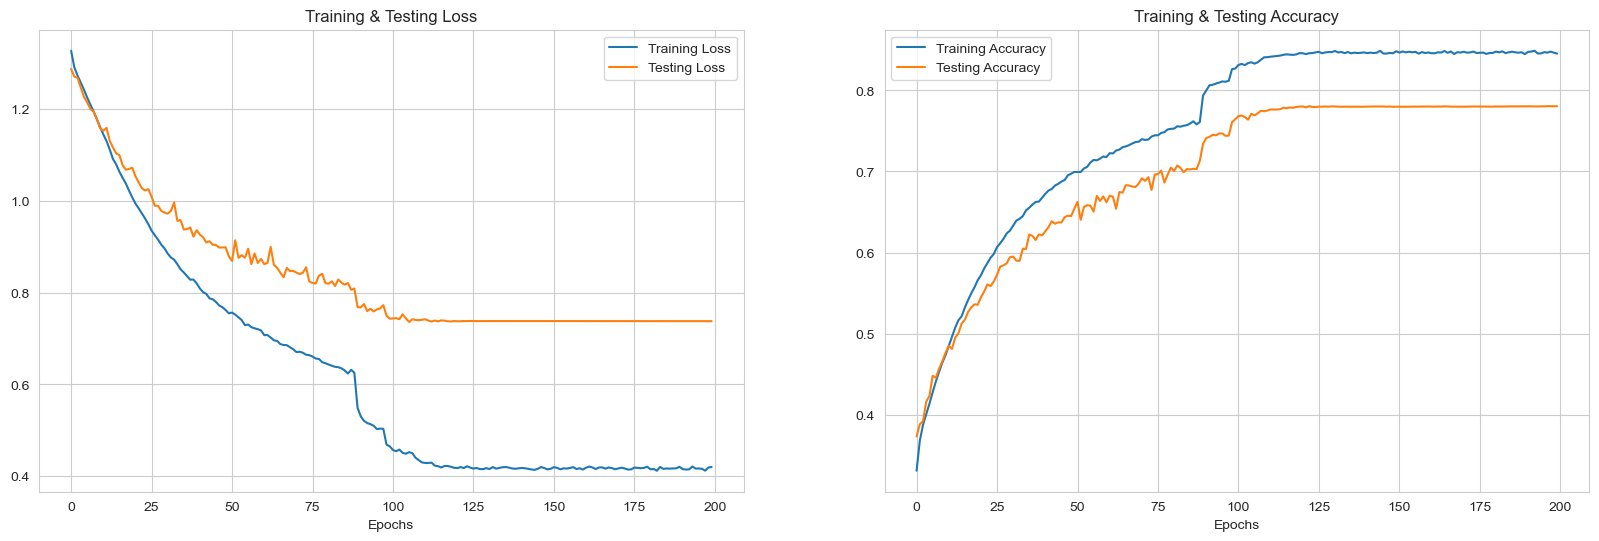

In [197]:
print("Accuracy of our model on test data : ", model.evaluate(x_test, y_test)[1] * 100, "%")

epochs = [i for i in range(EPOCH)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Сохранение графика потерь
loss_plot_path = os.path.join(save_dir, 'training_testing_loss_mel_mfcc_200_epoch.png')
fig.savefig(loss_plot_path)
plt.close(fig)

# Сохранение графика точности
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy.png')
fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label='Training Accuracy')
ax.plot(epochs, test_acc, label='Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs")
fig.set_size_inches(10, 6)
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy_mel_mfcc_200_epoch.png')
fig.savefig(accuracy_plot_path)
plt.close(fig)

782/782 [==============================] - 16s 19ms/step


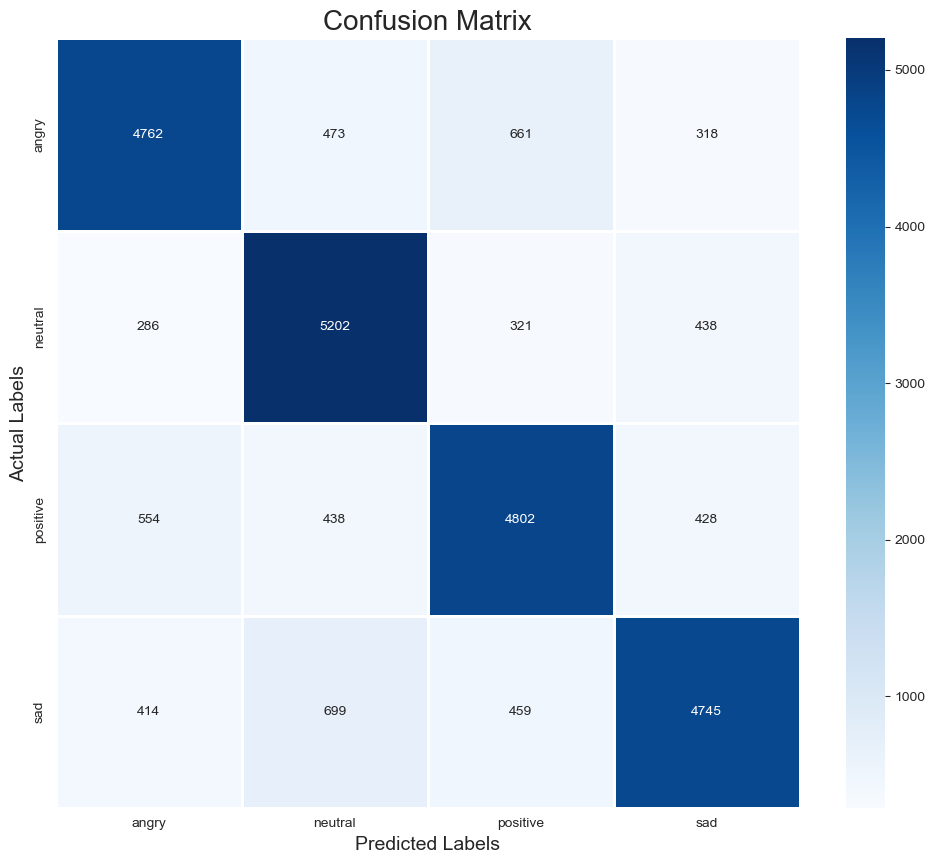

In [198]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)  
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()


In [199]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.79      0.77      0.78      6214
     neutral       0.76      0.83      0.80      6247
    positive       0.77      0.77      0.77      6222
         sad       0.80      0.75      0.77      6317

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.78     25000
weighted avg       0.78      0.78      0.78     25000


In [200]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("C:\\Users\\s5pen\\DataSpellProjects\\SER\\models\\two\\model_100k_mel_mfcc.json", "w")
json_file.write(model_json)
json_file.close()

### Обучение на ZCR & MFCC

In [201]:
# Чтение CSV-файла
file = pd.read_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_zcr_mfcc_100000.csv')

X = file.iloc[:, :-1].values
Y = file['labels'].values

encoder = OneHotEncoder()  # As this is a multiclass classification problem onehotencoding our Y.
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=0.9)  # Выбор числа компонент, сохраняющего 90% дисперсии
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(75000, 21) (75000, 4) (25000, 21) (25000, 4)


((75000, 14), (75000, 4), (25000, 14), (25000, 4))

In [202]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))  #  уменьшает размерность признаков в strides раз

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())  # преобразует в одномерный вектор
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))  # unites - количество эмоций для обучения
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, 14, 256)           1536      
                                                                 
 max_pooling1d_72 (MaxPooli  (None, 7, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_73 (Conv1D)          (None, 7, 256)            327936    
                                                                 
 max_pooling1d_73 (MaxPooli  (None, 4, 256)            0         
 ng1D)                                                           
                                                                 
 conv1d_74 (Conv1D)          (None, 4, 128)            163968    
                                                                 
 max_pooling1d_74 (MaxPooli  (None, 2, 128)          

In [203]:
#Обучение
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=EPOCH, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/200
1172/1172 [==============================] - 61s 49ms/step - loss: 1.3439 - accuracy: 0.3117 - val_loss: 1.3236 - val_accuracy: 0.3313 - lr: 0.0010
Epoch 2/200
1172/1172 [==============================] - 49s 42ms/step - loss: 1.3126 - accuracy: 0.3394 - val_loss: 1.3043 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 3/200
1172/1172 [==============================] - 52s 45ms/step - loss: 1.3015 - accuracy: 0.3583 - val_loss: 1.2873 - val_accuracy: 0.3728 - lr: 0.0010
Epoch 4/200
1172/1172 [==============================] - 51s 44ms/step - loss: 1.2869 - accuracy: 0.3762 - val_loss: 1.2810 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 5/200
1172/1172 [==============================] - 52s 44ms/step - loss: 1.2746 - accuracy: 0.3898 - val_loss: 1.2708 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 6/200
1172/1172 [==============================] - 50s 43ms/step - loss: 1.2652 - accuracy: 0.3970 - val_loss: 1.2640 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 7/200
1172/1172 [=================

782/782 [==============================] - 9s 11ms/step - loss: 0.8469 - accuracy: 0.7520
Accuracy of our model on test data :  75.20400285720825 %


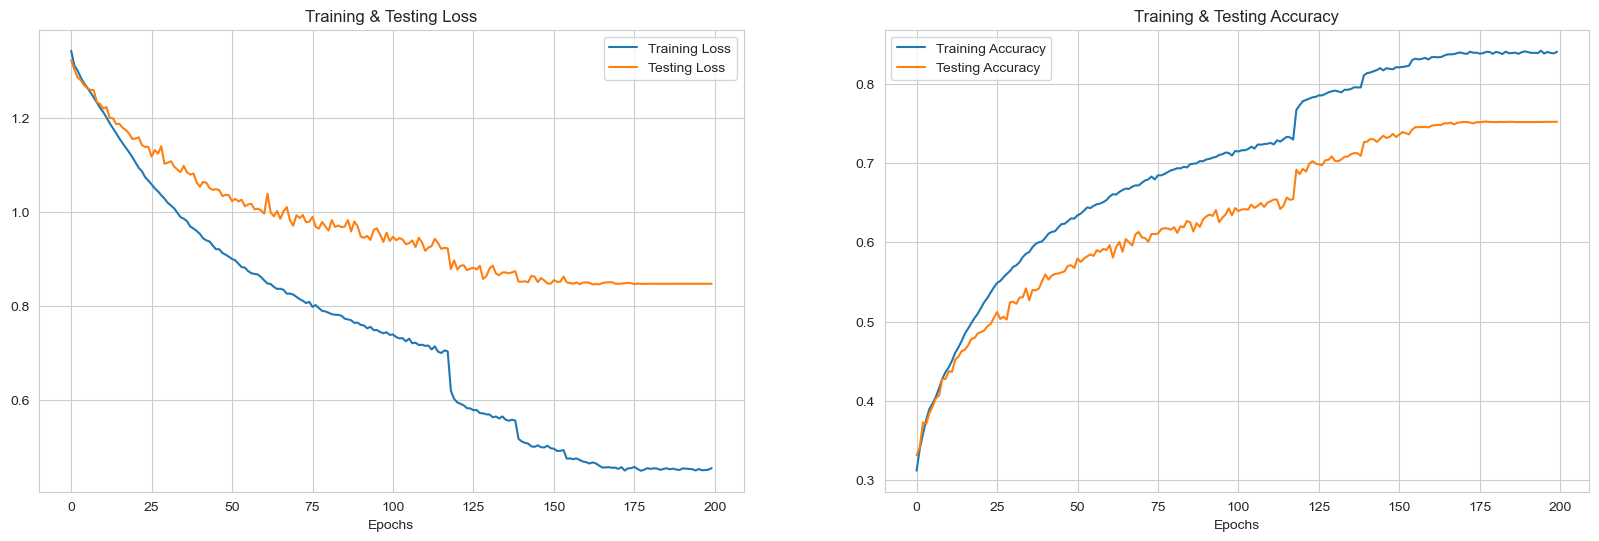

In [204]:
print("Accuracy of our model on test data : ", model.evaluate(x_test, y_test)[1] * 100, "%")

epochs = [i for i in range(EPOCH)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Сохранение графика потерь
loss_plot_path = os.path.join(save_dir, 'training_testing_loss_zcr_mfcc_200_epoch.png')
fig.savefig(loss_plot_path)
plt.close(fig)

# Сохранение графика точности
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy.png')
fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label='Training Accuracy')
ax.plot(epochs, test_acc, label='Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs")
fig.set_size_inches(10, 6)
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy_zcr_mfcc_200_epoch.png')
fig.savefig(accuracy_plot_path)
plt.close(fig)


782/782 [==============================] - 9s 11ms/step


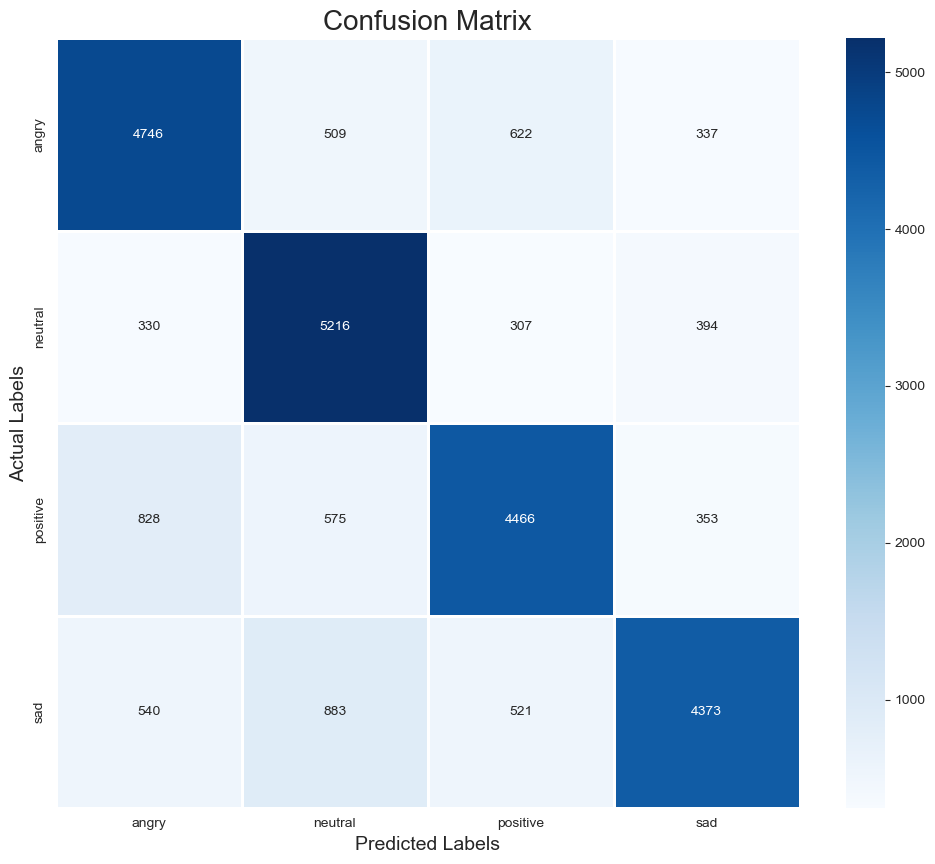

In [205]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [206]:
# df.head(10)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.74      0.76      0.75      6214
     neutral       0.73      0.83      0.78      6247
    positive       0.75      0.72      0.74      6222
         sad       0.80      0.69      0.74      6317

    accuracy                           0.75     25000
   macro avg       0.75      0.75      0.75     25000
weighted avg       0.75      0.75      0.75     25000


In [207]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("C:\\Users\\s5pen\\DataSpellProjects\\SER\\models\\two\\model_100k_zcr_mfcc_200_epoch.json", "w")
json_file.write(model_json)
json_file.close()

### Обучение на Mel & MFCC

In [208]:
# Чтение CSV-файла
file = pd.read_csv('C:\\Users\\s5pen\\DataSpellProjects\\SER\\features\\two\\features_zcr_mel_100000.csv')

X = file.iloc[:, :-1].values
Y = file['labels'].values

encoder = OneHotEncoder()  # As this is a multiclass classification problem onehotencoding our Y.
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

pca = PCA(n_components=0.9)  # Выбор числа компонент, сохраняющего 90% дисперсии
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

x_train.shape, y_train.shape, x_test.shape, y_test.shape


(75000, 130) (75000, 4) (25000, 130) (25000, 4)


((75000, 41), (75000, 4), (25000, 41), (25000, 4))

In [209]:
model = Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))  #  уменьшает размерность признаков в strides раз

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Flatten())  # преобразует в одномерный вектор
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))  # unites - количество эмоций для обучения
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 41, 256)           1536      
                                                                 
 max_pooling1d_76 (MaxPooli  (None, 21, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_77 (Conv1D)          (None, 21, 256)           327936    
                                                                 
 max_pooling1d_77 (MaxPooli  (None, 11, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_78 (Conv1D)          (None, 11, 128)           163968    
                                                                 
 max_pooling1d_78 (MaxPooli  (None, 6, 128)          

In [210]:
#Обучение
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history = model.fit(x_train, y_train, batch_size=64, epochs=EPOCH, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/200
1172/1172 [==============================] - 119s 100ms/step - loss: 1.3238 - accuracy: 0.3421 - val_loss: 1.2981 - val_accuracy: 0.3575 - lr: 0.0010
Epoch 2/200
1172/1172 [==============================] - 115s 98ms/step - loss: 1.3002 - accuracy: 0.3563 - val_loss: 1.2982 - val_accuracy: 0.3689 - lr: 0.0010
Epoch 3/200
1172/1172 [==============================] - 115s 98ms/step - loss: 1.2894 - accuracy: 0.3702 - val_loss: 1.2799 - val_accuracy: 0.3796 - lr: 0.0010
Epoch 4/200
1172/1172 [==============================] - 106s 90ms/step - loss: 1.2797 - accuracy: 0.3778 - val_loss: 1.2645 - val_accuracy: 0.3949 - lr: 0.0010
Epoch 5/200
1172/1172 [==============================] - 102s 87ms/step - loss: 1.2671 - accuracy: 0.3950 - val_loss: 1.2573 - val_accuracy: 0.3993 - lr: 0.0010
Epoch 6/200
1172/1172 [==============================] - 113s 96ms/step - loss: 1.2600 - accuracy: 0.4035 - val_loss: 1.2456 - val_accuracy: 0.4084 - lr: 0.0010
Epoch 7/200
1172/1172 [==========

782/782 [==============================] - 11s 14ms/step - loss: 0.8404 - accuracy: 0.7486
Accuracy of our model on test data :  74.86400008201599 %


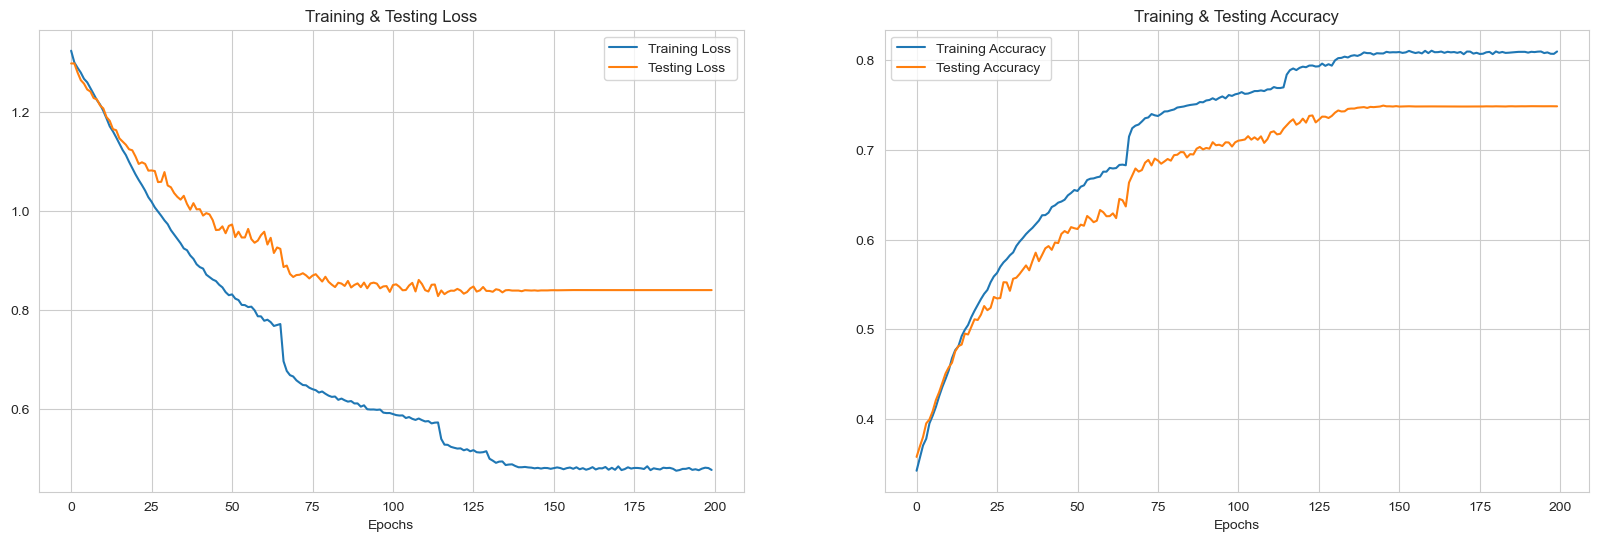

In [211]:
print("Accuracy of our model on test data : ", model.evaluate(x_test, y_test)[1] * 100, "%")

epochs = [i for i in range(EPOCH)]
fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(epochs, train_loss, label='Training Loss')
ax[0].plot(epochs, test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_acc, label='Training Accuracy')
ax[1].plot(epochs, test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

# Сохранение графика потерь
loss_plot_path = os.path.join(save_dir, 'training_testing_loss_zcr_mel_200_epoch.png')
fig.savefig(loss_plot_path)
plt.close(fig)

# Сохранение графика точности
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy.png')
fig, ax = plt.subplots()
ax.plot(epochs, train_acc, label='Training Accuracy')
ax.plot(epochs, test_acc, label='Testing Accuracy')
ax.set_title('Training & Testing Accuracy')
ax.legend()
ax.set_xlabel("Epochs")
fig.set_size_inches(10, 6)
accuracy_plot_path = os.path.join(save_dir, 'training_testing_accuracy_mel_200_epoch.png')
fig.savefig(accuracy_plot_path)
plt.close(fig)


782/782 [==============================] - 11s 14ms/step


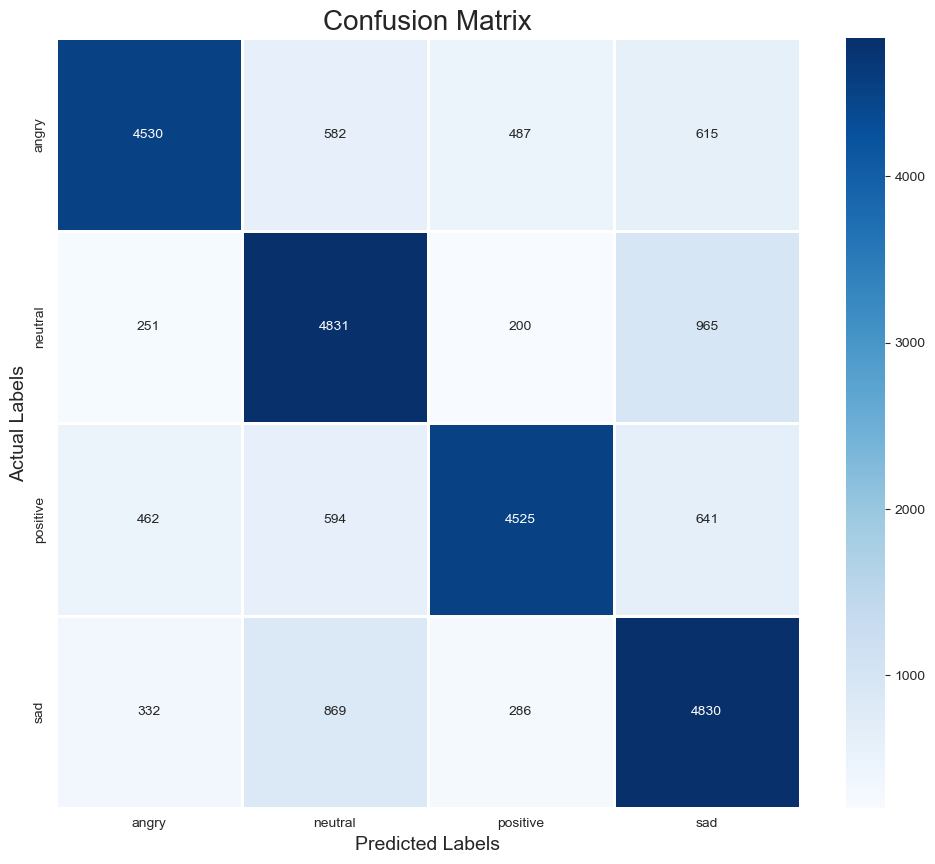

In [212]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [213]:
# df.head(10)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.81      0.73      0.77      6214
     neutral       0.70      0.77      0.74      6247
    positive       0.82      0.73      0.77      6222
         sad       0.69      0.76      0.72      6317

    accuracy                           0.75     25000
   macro avg       0.76      0.75      0.75     25000
weighted avg       0.76      0.75      0.75     25000


In [214]:
# Генерируем описание модели в формате json
model_json = model.to_json()
# Записываем модель в файл
json_file = open("C:\\Users\\s5pen\\DataSpellProjects\\SER\\models\\two\\model_100k_zcr_mel_200_epoch.json", "w")
json_file.write(model_json)
json_file.close()